In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore future warning regarding pysal/spaghetti

from pysal.lib import weights
from pysal.explore import esda
import numpy as np

import matplotlib.pyplot as plt
import seaborn
import contextily
import requests
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

import geopandas as gpd
from shapely.geometry import Point # Shapely for converting latitude/
import pandas as pd
import pymssql

database = "Pushing-P-DB"
table = "dbo.Training_Set"
user = "pushing_p"
password  = "t3stP@ssword"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"


# Retrieve Training Data for Poisson Model

conn = pymssql.connect(server, user, password, database)

cursor = conn.cursor()

# Use a Selct Query to get rows from SQL table
cursor.execute(f"SELECT * FROM {table}")

# Iterate over rows stored in cursor and place them in a list
row_list = []
for row in cursor:
    row_list.append(row)

# Convert list of rows into a Pandas DataFrame
df = pd.DataFrame(row_list, columns = ['State','County','Population Estimate (2019)','Urban Category',
'Median Household Income (2019)','Number of Unemployed People (2019)','Unemployment Rate (2019)',
'Number of Uninsured (2019)','Latitude','Longitude'])



In [2]:
df.dtypes

State                                 object
County                                object
Population Estimate (2019)            object
Urban Category                        object
Median Household Income (2019)        object
Number of Unemployed People (2019)    object
Unemployment Rate (2019)              object
Number of Uninsured (2019)             int64
Latitude                              object
Longitude                             object
dtype: object

In [3]:
# Convert columns to proper data types
df[['Median Household Income (2019)','Number of Unemployed People (2019)']] = df[['Median Household Income (2019)','Number of Unemployed People (2019)']].astype(int)
df['Unemployment Rate (2019)'] = df['Unemployment Rate (2019)'].astype(float)
df['Population Estimate (2019)'] = df['Population Estimate (2019)'].astype(int)
df['Urban Category'] = df['Urban Category'].astype(int)
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

# Make new column with % of Uninsured
df['% Uninsured (2019)'] = df['Number of Unemployed People (2019)']/df['Population Estimate (2019)'] * 100

In [4]:
df.head()

,State,County,Population Estimate (2019),Urban Category,Median Household Income (2019),Number of Unemployed People (2019),Unemployment Rate (2019),Number of Uninsured (2019),Latitude,Longitude,% Uninsured (2019)
0,KS,Morris County,5620,0,54775,82,2.7,480,38.688204,-96.651448,1.459075
1,TX,Dickens County,2211,0,41973,29,4.3,299,33.615363,-100.787617,1.311624
2,WI,Oconto County,37930,1,66401,724,3.5,2051,44.996575,-88.206516,1.908779
3,IA,Emmet County,9208,0,55635,137,2.6,490,43.377984,-94.669370,1.487837
4,NE,Holt County,10067,0,54474,145,2.5,773,42.459287,-98.784766,1.440350


In [5]:
df.shape

(3119, 11)

In [6]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [7]:
gdf.head()

,State,County,Population Estimate (2019),Urban Category,Median Household Income (2019),Number of Unemployed People (2019),Unemployment Rate (2019),Number of Uninsured (2019),Latitude,Longitude,% Uninsured (2019),geometry
0,KS,Morris County,5620,0,54775,82,2.7,480,38.688204,-96.651448,1.459075,POINT (-96.65145 38.68820)
1,TX,Dickens County,2211,0,41973,29,4.3,299,33.615363,-100.787617,1.311624,POINT (-100.78762 33.61536)
2,WI,Oconto County,37930,1,66401,724,3.5,2051,44.996575,-88.206516,1.908779,POINT (-88.20652 44.99657)
3,IA,Emmet County,9208,0,55635,137,2.6,490,43.377984,-94.669370,1.487837,POINT (-94.66937 43.37798)
4,NE,Holt County,10067,0,54474,145,2.5,773,42.459287,-98.784766,1.440350,POINT (-98.78477 42.45929)


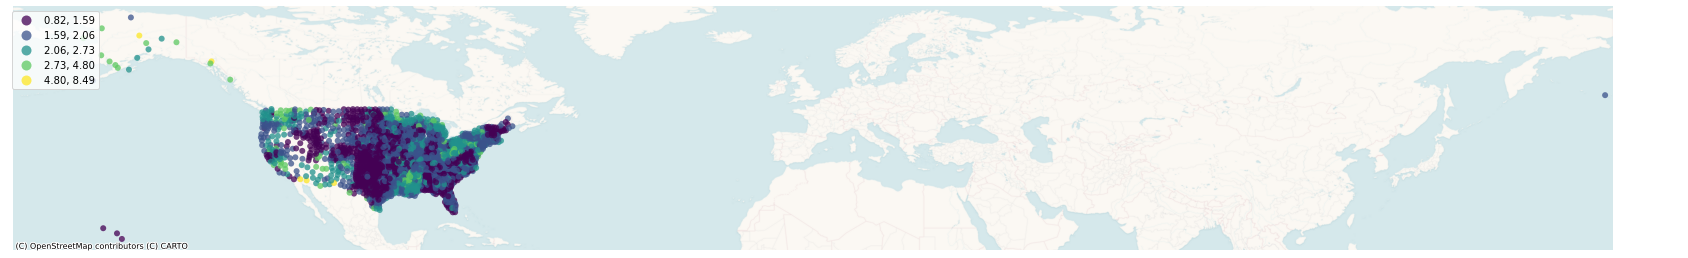

In [8]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(30, 5))

# Build choropleth
gdf.plot(
    column='% Uninsured (2019)', 
    cmap='viridis', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=gdf.crs, 
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes


ax.set_axis_off();

In [9]:
gdf.dtypes

State                                   object
County                                  object
Population Estimate (2019)               int64
Urban Category                           int64
Median Household Income (2019)           int64
Number of Unemployed People (2019)       int64
Unemployment Rate (2019)               float64
Number of Uninsured (2019)               int64
Latitude                               float64
Longitude                              float64
% Uninsured (2019)                     float64
geometry                              geometry
dtype: object

In [10]:
variable_names = [
    'Urban Category',
    'Median Household Income (2019)',
    'Unemployment Rate (2019)'
]


In [11]:
from pysal.model import spreg
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    gdf[['% Uninsured (2019)']].values, 
    # Independent variables
    gdf[variable_names].values,
    # Dependent variable name
    name_y='% Uninsured', 
    # Independent variable name
    name_x=variable_names
)

In [12]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : % Uninsured                Number of Observations:        3119
Mean dependent var  :      1.7959                Number of Variables   :           4
S.D. dependent var  :      0.5121                Degrees of Freedom    :        3115
R-squared           :      0.8031
Adjusted R-squared  :      0.8029
Sum squared residual:     160.999                F-statistic           :   4235.9661
Sigma-square        :       0.052                Prob(F-statistic)     :           0
S.E. of regression  :       0.227                Log likelihood        :     196.484
Sigma-square ML     :       0.052                Akaike info criterion :    -384.969
S.E of regression ML:      0.2272                Schwarz criterion     :    -360.787

-----------------------------------------------------------------------------

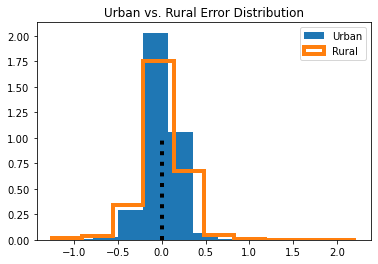

In [13]:
# Create a Boolean (True/False) with whether a
# property is urban or not
is_urban = gdf['Urban Category'].astype(bool)
# Split residuals (m1.u) between coastal and not
urban = m1.u[is_urban]
not_urban = m1.u[~is_urban]
# Create histogram of the distribution of coastal residuals
plt.hist(urban, density=True, label='Urban')
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_urban, 
    histtype='step',
    density=True, 
    linewidth=4, 
    label='Rural'
)
# Add Line on 0
plt.vlines(0,0,1, linestyle=":", color='k', linewidth=4)
# Add legend
plt.legend()
plt.title('Urban vs. Rural Error Distribution')
# Display
plt.show()

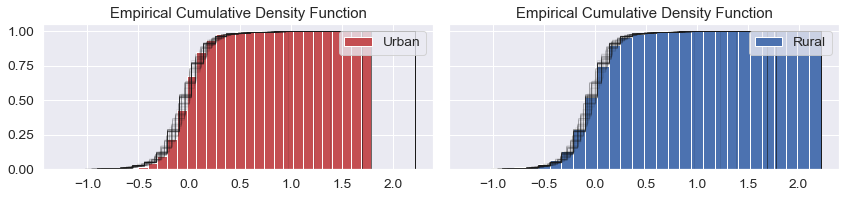

In [14]:
n_simulations = 100
seaborn.set(font_scale = 1.25)
f, ax = plt.subplots(1,2,figsize=(12,3), sharex=True, sharey=True)
ax[0].hist(
    urban, 
    color=['r'], 
    alpha=1, 
    density=True, 
    bins=30, 
    label='Urban', 
    cumulative=True
)
ax[1].hist(
    not_urban, 
    color=['b'], 
    alpha=1,
    density=True, 
    bins=30, 
    label='Rural', 
    cumulative=True
)
for simulation in range(n_simulations):
    shuffled_residuals = m1.u[np.random.permutation(m1.n)]
    random_urban, random_urban = (
        shuffled_residuals[is_urban], 
        shuffled_residuals[~is_urban]
    )
    ax[0].hist(
        random_urban, 
        density=True, 
        histtype='step',
        color='k', alpha=.05, bins=30, 
        label=None, 
        cumulative=True
    )
    ax[1].hist(
        random_urban, 
        density=True, 
        histtype='step',
        color='k', alpha=.05, bins=30, 
        label=None, 
        cumulative=True
    )
    
ax[0].legend()
ax[1].legend()
ax[0].set_title('Empirical Cumulative Density Function')
ax[1].set_title('Empirical Cumulative Density Function')
plt.tight_layout()
plt.show()

### Plot of the observed residual distributions vs. random distributions for Urban and Rural Counties

#### 1160 Urban Counties vs. 1959 Rural Counties

- The black lines represent our simulations, and the colored patches below them represents the observed distribution of residuals. 

- If the black lines tend to be on the **left** of the colored patch, then, the simulations (where prediction error is totally random with respect to our categories of "Urban" and "Rural") tend to have more **negative residuals** than our actual model **(over-predicting)**

- If the black lines tend to be on the **right**, then they tend to have more **positive residuals** than our actual model **(under-predicting)**

#### Our simulations provide direct evidence for the claim that our model may be systematically `over-predicting` Urban % Uninsured

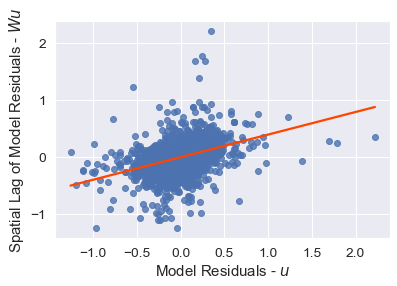

In [15]:
knn = weights.KNN.from_dataframe(gdf, k=1)
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    m1.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

### Our prediction errors tend to cluster! Above, we show the relationship between our prediction error at each site and the prediction error at the site nearest to it.

### Here, we’re using this nearest site to stand in for the surroundings of a County. This means that, when the model tends to **over-predict** a given County's % Uninsured, sites around that County are *ALSO* more likely to also be over-predicted!

### An interesting property of this relationship is that it tends to stabilize as the number of nearest neighbors used to construct each County's surroundings increases

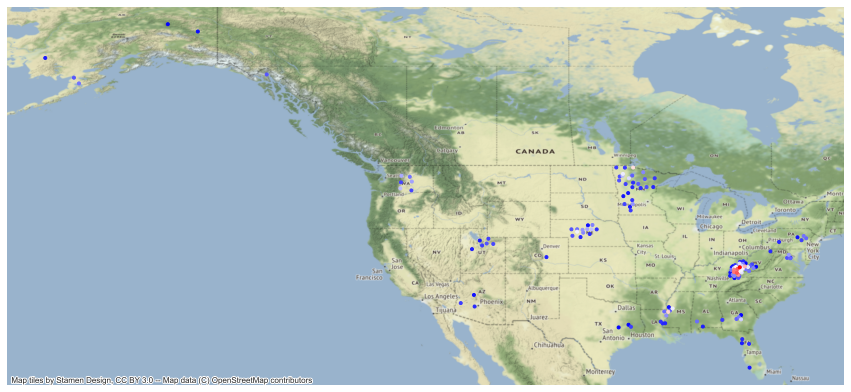

In [16]:
# Re-weight W to 10 nearest neighbors
plt.rcParams["figure.figsize"] = (15,15);
knn.reweight(k=10, inplace=True)

# Row standardise weights
knn.transform = 'R'
# Run (Local Spatial Autocorrelation) LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)

# q values: 1 HH, 2 LH, 3 LL, 4 HL

# Select only LISA cluster cores where the model overpredicts
error_clusters = (outliers.q % 2 == 1)
# Filter out non-significant clusters
error_clusters &= (outliers.p_sim <= .001)
# Add `error_clusters` and `local_I` columns
ax = gdf.assign(
    error_clusters = error_clusters,
    local_I = outliers.Is
# Retain error clusters only
).query(
    "error_clusters"
# Sort by I value to largest plot on top
).sort_values(
    'local_I'
# Plot I values
).plot(
    'local_I', cmap='bwr', marker='.'
)
# Add basemap
contextily.add_basemap(ax, crs=gdf.crs)
# Remove axes
ax.set_axis_off();


- #### Here, we are measuring spatial autocorrelation for our Counties using **Local Moran's I** Statistics. 
- #### **ESDA** is Exploratory Spatial Data Analysis
- #### [What is Moran's I?](https://www.statisticshowto.com/morans-i/#:~:text=What%20is%20Moran's%20I%3F,the%20observations%20are%20not%20independent) Moran's I is a correlation coefficient that measures the overall spatial autocorrelation of your data set. In other words, it measures how one object is similar to others surrounding it. If objects are attracted (or repelled) by each other, it means that the observations are not independent.

- #### The highlighted areas tend to be locations where our model significantly **overpredicts** the % Uninsured both for that specific observation and observations in its immediate surroundings. 
- #### This is critical since, if we can identify how these areas are structured — in other words, if they have a *consistent* geography that we can model — then we might make our predictions even better, or at least not systematically mis-predict prices in some areas while correctly predicting prices in other areas

In [17]:
variable_names = [
    'Median Household Income (2019)',
    'Unemployment Rate (2019)'
]


m5 = spreg.OLS_Regimes(
    # Dependent variable
    gdf[['% Uninsured (2019)']].values, 
    # Independent variables
    gdf[variable_names].values,
    # Variable specifying neighborhood membership
    gdf['Urban Category'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y='% Uninsured', 
    # Independent variables names
    name_x=variable_names
)

In [18]:
print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : % Uninsured                Number of Observations:        3119
Mean dependent var  :      1.7959                Number of Variables   :           6
S.D. dependent var  :      0.5121                Degrees of Freedom    :        3113
R-squared           :      0.8242
Adjusted R-squared  :      0.8240
Sum squared residual:     143.740                F-statistic           :   2919.6755
Sigma-square        :       0.046                Prob(F-statistic)     :           0
S.E. of regression  :       0.215                Log likelihood        :     373.318
Sigma-square ML     :       0.046                Akaike info criterion :    -734.636
S.E of regression ML:      0.2147                Schwarz criterion     :    -698.365

---------------------------------------------------------

In [19]:
# Estimated Linear Regression Coefficients
m5.betas

array([[-1.59495070e-01],
       [ 1.24478962e-05],
       [ 3.29376874e-01],
       [-8.83255391e-02],
       [ 5.58409536e-06],
       [ 4.03888412e-01]])